In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Image processing
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import skimage.io
import skimage.transform
from imageio import imread

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

print(os.listdir('/content/drive/My Drive/Colab Notebooks/flags1'))
directory = os.listdir('/content/drive/My Drive/Colab Notebooks/flags1')

['France', 'Italy', 'USA', 'Switzerland', 'Russia', 'UK', 'germany', 'spain', 'Canada', 'India']


In [96]:
!pip install split-folders

In [97]:
import split_folders
# Create a new folder flags1 and give as output file
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#split_folders.ratio('input_folder', output="output", seed=1337, ratio=(.8, .1, .1))
split_folders.ratio('/content/drive/My Drive/Colab Notebooks/flags1', output="/content/flags1", seed=1337, ratio=(.8,.2))

Copying files: 2073 files [20:03,  1.72 files/s]


In [110]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.densenet import DenseNet121,preprocess_input

#vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

29089792/29084464 [==============================] - 2s 0us/step


In [111]:
# Freeze the layers except the last 4 layers
for layer in densenet.layers[:-4]:
  layer.trainable = False
# Check the trainable status of the individual layers
for layer in densenet.layers:
	  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fbc0742ed30> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbc0742eef0> False
<keras.layers.convolutional.Conv2D object at 0x7fbc0742e748> False
<keras.layers.normalization.BatchNormalization object at 0x7fbc0756b438> False
<keras.layers.core.Activation object at 0x7fbc0756bc18> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbc0756b7f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbc0756b3c8> False
<keras.layers.normalization.BatchNormalization object at 0x7fbc0756bb38> False
<keras.layers.core.Activation object at 0x7fbc07477b00> False
<keras.layers.convolutional.Conv2D object at 0x7fbc07494e48> False
<keras.layers.normalization.BatchNormalization object at 0x7fbc071da828> False
<keras.layers.core.Activation object at 0x7fbc071e0f28> False
<keras.layers.convolutional.Conv2D object at 0x7fbc07173f98> False
<keras.layers.merge.Concatenate object at 0x7fbc07173f60> False
<keras.layers.normalization.

In [112]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()
# Add the vgg/mobilenet convolutional base model
model.add(densenet)
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 2, 2, 1024)        7037504   
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5130      
Total params: 9,140,298
Trainable params: 2,141,706
Non-trainable params: 6,998,592
_________________________________________________________________


In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True)

In [0]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [115]:
train_generator = train_datagen.flow_from_directory('/content/flags1/train',target_size=(64,64),
        batch_size=30,
        class_mode='categorical')

Found 1074 images belonging to 10 classes.


In [116]:
validation_generator = test_datagen.flow_from_directory('/content/flags1/val',
        target_size=(64,64),
        class_mode='categorical')

Found 272 images belonging to 10 classes.


In [0]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h1'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [119]:
training=model.fit(train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data = validation_generator, 
        validation_steps = 30,
        callbacks=[earlystopper1, checkpointer1])

Epoch 1/20
100/100 [==============================] - 50s 500ms/step - loss: 1.8888 - acc: 0.4554 - val_loss: 2.4950 - val_acc: 0.5373

Epoch 00001: val_acc improved from -inf to 0.53728, saving model to best_model1.h1
Epoch 2/20
100/100 [==============================] - 40s 398ms/step - loss: 1.1966 - acc: 0.6011 - val_loss: 2.0525 - val_acc: 0.5526

Epoch 00002: val_acc improved from 0.53728 to 0.55263, saving model to best_model1.h1
Epoch 3/20
100/100 [==============================] - 39s 388ms/step - loss: 1.0597 - acc: 0.6516 - val_loss: 3.1724 - val_acc: 0.5446

Epoch 00003: val_acc did not improve from 0.55263
Epoch 4/20
100/100 [==============================] - 38s 384ms/step - loss: 1.0096 - acc: 0.6667 - val_loss: 3.0622 - val_acc: 0.5800

Epoch 00004: val_acc improved from 0.55263 to 0.58004, saving model to best_model1.h1
Epoch 5/20
100/100 [==============================] - 38s 376ms/step - loss: 0.9598 - acc: 0.6764 - val_loss: 4.2396 - val_acc: 0.6086

Epoch 00005: va

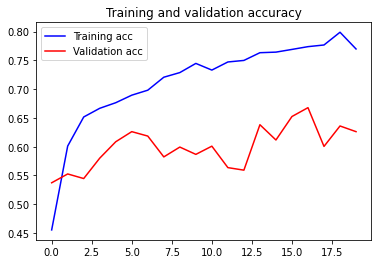

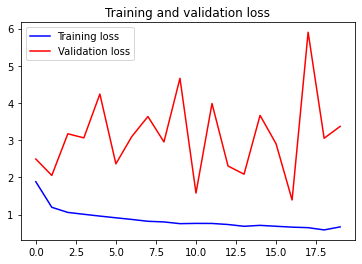

In [120]:
acc = training.history['acc']
val_acc = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()